<a href="https://colab.research.google.com/github/yifeili6/DL_BP_tutorial/blob/main/tutorial_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic ML


Linear:
https://towardsdatascience.com/sgdregressor-with-scikit-learn-untaught-lessons-you-need-to-know-cf2430439689

In [ ]:
# download data
# process data return X, Y np array
!wget https://github.com/yifeili6/data2/blob/main/sc_chemo_4sets.mat?raw=true
# # rename the file
!mv sc_chemo_4sets.mat?raw=true sc_chemo_4sets.mat


def process_data():
  mat = scipy.io.loadmat('sc_chemo_4sets.mat')

  all_data   = []
  target     = []
  cond_indx  = {}
  indx       =  0
  keys_y     = ['WT_y_steady_clim','WT_y_steady_cnlim1','WT_y_steady_cnlim2', 'WT_y_steady_nlim']
  keys_sig   = ['WT_sig_steady_clim','WT_sig_steady_cnlim1','WT_sig_steady_cnlim2', 'WT_sig_steady_nlim']
  conditions = ['clim', 'cnlim1', 'cnlim2', 'nlim']

  for ky, ks, kc in zip(keys_y, keys_sig, conditions):
      snf1, tor = mat[ks].item() # B , C (31,1)
      y         = mat[ky] # B , C (31,23)
      all_var   = np.concatenate((y, snf1, tor), axis=1) # B , C (31,25)
      all_data.append(all_var)
      cond_indx[kc] = [indx, indx + len(y)]
      indx      =  indx + len(y)

      target.append([kc]*len(y))

      #print(f'shapes snf1 = {snf1.shape}, torc1 ={tor.shape}, ys = {y.shape}, all_vars = {all_var.shape}')
      #print('---------------------')

  all_data = np.array(all_data)
  all_data = all_data.reshape(-1,all_data.shape[-1])
  target = list(itertools.chain.from_iterable(target))
  #all_data.shape

  le = preprocessing.LabelEncoder()
  le.fit(target)
  list(le.classes_)
  target = le.transform(target)
  le.inverse_transform([0, 1, 2, 3])

  dX = all_data
  dY = target
  return dX, dY

--2023-05-01 20:50:47--  https://github.com/yifeili6/data2/blob/main/sc_chemo_4sets.mat?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yifeili6/data2/raw/main/sc_chemo_4sets.mat [following]
--2023-05-01 20:50:47--  https://github.com/yifeili6/data2/raw/main/sc_chemo_4sets.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yifeili6/data2/main/sc_chemo_4sets.mat [following]
--2023-05-01 20:50:47--  https://raw.githubusercontent.com/yifeili6/data2/main/sc_chemo_4sets.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [ ]:
import abc

class supervised_backbone(abc.ABC):
    @abc.abstractmethod
    def __init__(self, filename: str, **kwargs):
      ...

    @abc.abstractmethod
    def preprocess(self, ):
      ...

    @abc.abstractmethod
    def split_data(self, filename: str, **kwargs):
      ...


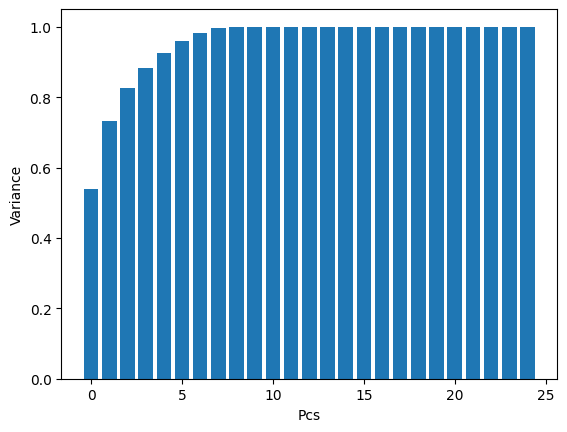

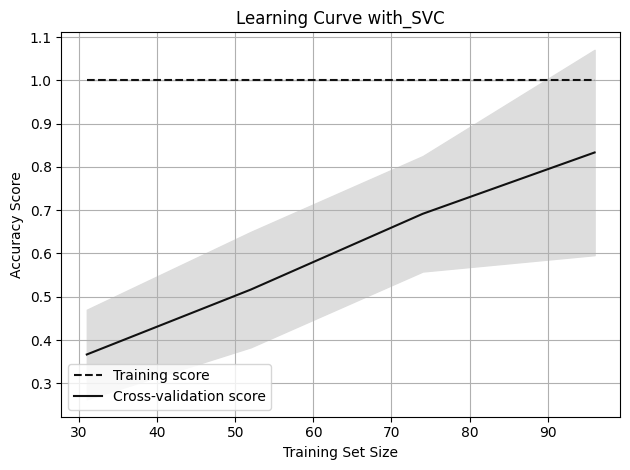

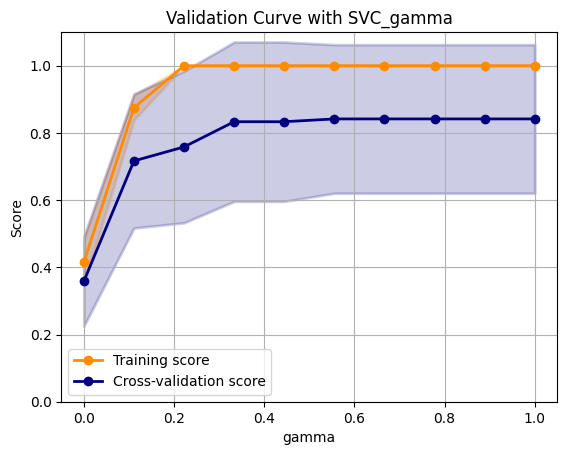

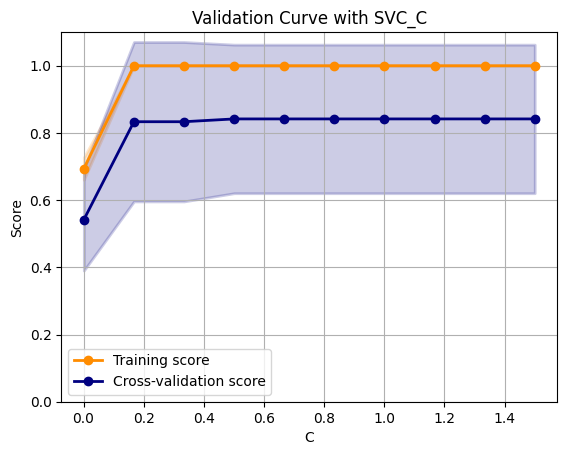

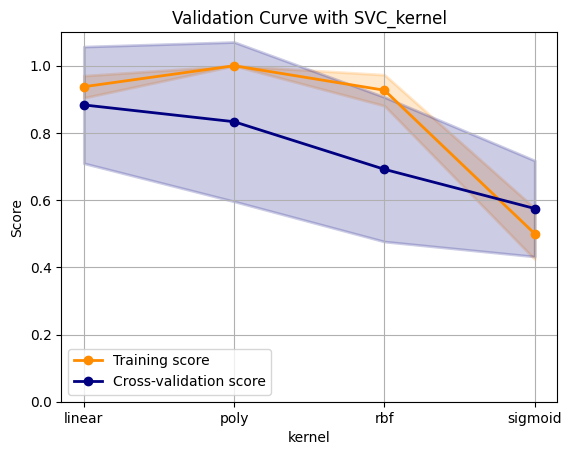

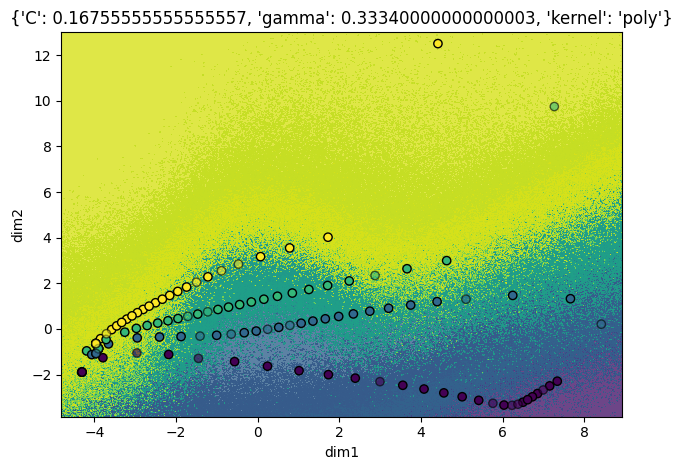

[[7 0 0 0]
 [0 7 0 0]
 [0 0 5 0]
 [0 0 0 5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

1.0 1.0


In [ ]:
from typing import *
import scipy.io
import numpy as np
from sklearn import preprocessing
import time
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import compute_sample_weight
import sklearn.model_selection as ms
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix, fbeta_score, make_scorer, balanced_accuracy_score, accuracy_score#, plot_roc_curve
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

class cus_calssifier(supervised_backbone):
    def __init__(self, dX: np.ndarray, dY: np.ndarray, **kwargs) -> None:
        #self.filename: str = filename
        #self.dX, self.dY = self.preprocess
        self.dX, self.dY = dX, dY

    @property
    def preprocess(self, ):
      assert self.dX.shape[0]==self.dY.shape[0], "X, Y need to have same number of samples (batch size)"
      assert type(dX).__module__ == np.__name__, "X shoud be np array"
      assert type(dY).__module__ == np.__name__, "Y shoud be np array"
      return self.dX, self.dY


    @staticmethod
    def split_data(dX: np.ndarray, dY: Union[np.ndarray, List], test_size: float=0.2):
        #Split the data
        np.random.seed(10)
        dX_train, dX_test, dY_train, dY_test = ms.train_test_split(dX, dY, test_size=test_size, random_state=0)
        return dX_train, dX_test, dY_train, dY_test

    @staticmethod
    def normalize_data(*unnormalized_data: np.ndarray):
        scaler = StandardScaler()
        scaler.fit(unnormalized_data[0]) #Fit (normalize) only the first training data
        return tuple(scaler.transform(d) for d in unnormalized_data)

    def svm_fit(self, dX_train: np.ndarray, dY_train: np.ndarray):
      estimator = SVC(random_state = 1)
      parameters = {'gamma':list(np.linspace(0.0001,1,10)), 'C':list(np.linspace(0.001,1.5,10)),
                    'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
      clf = GridSearchCV(estimator = estimator, param_grid = parameters, return_train_score = True, n_jobs = -1)
      clf.fit(dX_train, dY_train)
      return clf

    def predict(self, clf, *data: np.ndarray):
      return tuple(clf.predict(d) for d in data)

    def pca_fit(self, X: np.ndarray):
      # preprocess dataset, split into training and test part
      X = StandardScaler().fit_transform(X)
      pca = PCA()
      X = pca.fit_transform(X)
      plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum())
      plt.xlabel('Pcs')
      plt.ylabel('Variance')
      plt.savefig('Data1_scree')
      plt.show()
      return X



    def plot_boundary(self,clf, dX_train, dY_train, dX_test, dY_test):
      h = .01
      X = np.concatenate((dX_train, dX_test), axis = 0)
      #Y = np.concatenate((dY_train, dY_test), axis = 0)

      x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
      y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))


      shape = xx.ravel().shape[0]
      if hasattr(clf, "decision_function"):
          Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.random.randn(shape, dX_train.shape[1]-2)])
      else:
          Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

      # Put the result into a color plot
      Z = Z.reshape(xx.shape)
      plt.contourf(xx, yy, Z, alpha=.8)

      # Plot the training points
      plt.scatter(dX_train[:, 0], dX_train[:, 1], c=dY_train,
                  edgecolors='k')
      # Plot the testing points
      plt.scatter(dX_test[:, 0], dX_test[:, 1], c=dY_test,
                  edgecolors='k', alpha=0.6)
      plt.title("{}".format(clf.best_params_))
      plt.xlabel('dim1')
      plt.ylabel('dim2')

      plt.tight_layout()
      #plt.savefig("Boundary_{}_{}".format(inputData,name))
      plt.show()



    def plot_learn_val_curve(self, clf, dX: np.ndarray, dY: np.ndarray):
      # learning curve
      train_sizes, train_scores, test_scores = learning_curve(
      clf.best_estimator_, dX, dY,
      scoring="accuracy", n_jobs=-1)
      plt.title("Learning Curve with_{}".format(clf.estimator.__class__.__name__))
      plt.grid(True)
      train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1),
      test_mean, test_std   = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
      plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
      plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
      plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
      plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
      plt.legend(loc="best")
      plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
      plt.tight_layout()
      plt.savefig("Learn_{}".format(clf.estimator.__class__.__name__))
      plt.show()

      for par_key, par_value in zip(list(clf.param_grid.keys()), list(clf.param_grid.values())):
          train_scores, test_scores = validation_curve(
          clf.best_estimator_, dX, dY, param_name=par_key, param_range=par_value,
          scoring="accuracy", n_jobs=-1)
          train_scores_mean = np.mean(train_scores, axis=1)
          train_scores_std = np.std(train_scores, axis=1)
          test_scores_mean = np.mean(test_scores, axis=1)
          test_scores_std = np.std(test_scores, axis=1)
          plt.title("Validation Curve with {}_{}".format(clf.estimator.__class__.__name__, par_key))
          plt.grid(True)
          plt.xlabel("{}".format(par_key))
          plt.ylabel("Score")
          plt.ylim(0.0, 1.1)
          lw = 2
          plt.plot(par_value, train_scores_mean, label="Training score",
                        color="darkorange", lw=lw, marker='o')
          plt.fill_between(par_value, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.2,
                            color="darkorange", lw=lw)
          plt.plot(par_value, test_scores_mean, label="Cross-validation score",
                        color="navy", lw=lw, marker='o')
          plt.fill_between(par_value, test_scores_mean - test_scores_std,
                            test_scores_mean + test_scores_std, alpha=0.2,
                            color="navy", lw=lw)
          plt.legend(loc="best")
          plt.savefig("Valid_{}_{}".format(clf.estimator.__class__.__name__, par_key))
          plt.show()

    def run_classifier(self, model: str='svm', pca_trans_X: bool = True, normlize_X_data: bool = False):
      dX = self.dX
      dY = self.dY
      if pca_trans_X == True:
        dX = self.pca_fit(dX)
      dX_train, dX_test, dY_train, dY_test = self.split_data(dX, dY)
      if normlize_X_data == True:
         dX_train, dX_test  = self.normalize_data(dX_train, dX_test)
      if model == 'svm':
        clf = self.svm_fit(dX_train, dY_train)


      predictions = self.predict(clf, dX_test)
      predictions = predictions[0]
      self.plot_learn_val_curve(clf, dX, dY)
      self.plot_boundary(clf, dX_train, dY_train, dX_test, dY_test)

      print(confusion_matrix(dY_test,predictions))
      print(classification_report(dY_test,predictions))
      print(balanced_accuracy_score(dY_test,predictions),accuracy_score(dY_test,predictions))


#dX data X nd array (B, C)
#dY label, ndarry (B,)
dX, dY = process_data()
#dX = np.random.randn(120,15)
#dY = np.random.randint(1,5, (120,))


classifer = cus_calssifier(dX = dX, dY = dY)
#condtion = dict(pca_trans_X=False, normlize_X_data=True, model='svm')
condtion = dict(pca_trans_X=True, normlize_X_data=False, model='svm')
classifer.run_classifier(**condtion)
